# Logistic growth

In this document, four parameter estimation techniques are presented (efforts will be made to compare them), applied on a simple **logistic growth model** for one population. First, we will do a _linear regression_ on the parameters. Next, we do a so-called _nonlinear least squares regression_. The resting techniques will follow the treatment in Ramsay and Hooker (2017). They are referred to as _gradient matching_ and _parameter cascading_

First of all, we define some necessary functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
from scipy import optimize
from scipy import interpolate

def log_equation(t, x, *args):
    """
    Returns the logistic growth differential equation for one populations.
    Should receive two parameters: (r, a)
    """
    r = args[0]
    a = args[1]
    return x * (r + a*x)

def add_noise(data, sigma):
    """
    Adds Gaussian noise with mean 0 and standard deviation sigma
    to each entry of the given data
    """
    return data + np.random.normal(scale=sigma, size=np.shape(data))

def clean_data(data, eps):
    """
    Reduces to zero the entries of data with value < eps
    """
    data[data < eps] = 0
    return data

## Data generation with given parameters

In [2]:
# ODE parameters
r = 0.33    # Rate of growth
a = -0.002    # 
params = (r, a)

# Additional conditions
x0 = np.array([0.5])     # Initial population
t0 = 0                   # Time evaluation starting point
tf = 40                  # Time evaluation finishing point

# Time points to be displayed
num_tpoints = 20
t_points = np.linspace(t0, tf, num_tpoints)

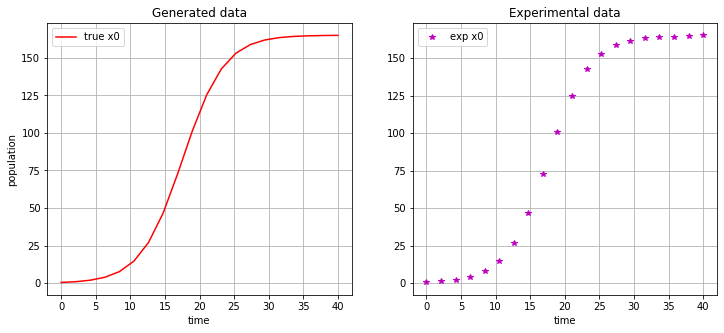

In [3]:
sigma = num_tpoints**-0.5    # Standard deviation of noise
eps = 1E-4                   # Data below this value will be set to zero

sol_log = integrate.solve_ivp(log_equation, (t0,tf), x0, args=params, t_eval=t_points)
data_log = add_noise(sol_log.y, sigma)
data_log = clean_data(data_log, eps)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
ax0.plot(t_points, sol_log.y[0], '-r', label='true x0')
ax0.set_title('Generated data')
ax0.set_ylabel('population')
ax0.set_xlabel('time')
ax0.legend(loc='best')
ax0.grid()
ax1.plot(t_points, data_log[0], 'm*', label='exp x0')
ax1.set_title('Experimental data')
ax1.set_xlabel('time')
ax1.legend(loc='best')
ax1.grid()
plt.show()

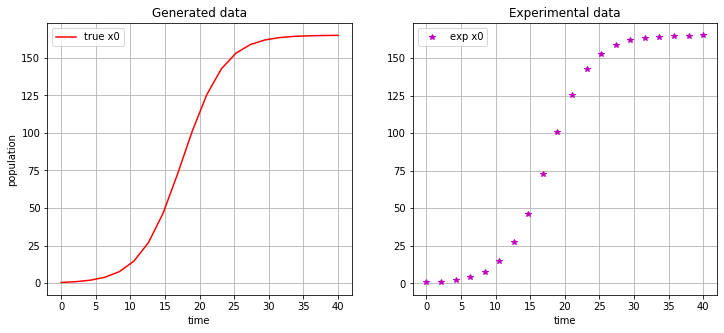

"\ndef plot_solution(t_points, sol):\n    plt.plot(t_points, sol_log.y[0], '-r', label='x0')\n    plt.grid()\n    plt.legend(loc='best')\n    plt.ylabel('population')\n    plt.xlabel('time')\n    plt.show()\n"

In [47]:
"""
def plot_solution(t_points, sol):
    plt.plot(t_points, sol_log.y[0], '-r', label='x0')
    plt.grid()
    plt.legend(loc='best')
    plt.ylabel('population')
    plt.xlabel('time')
    plt.show()
"""

## Parameter estimation

### Linear least squares

(0.31587366300199005, -0.0019539533350815107)


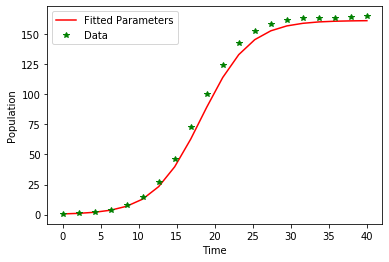

In [4]:
b = np.zeros(num_tpoints)
A = np.zeros((num_tpoints,2))
for i in range(num_tpoints-1):
    b[i] = np.log(data_log[0,i+1]/data_log[0,i])/(t_points[i+1]-t_points[i])
    A[i] = [1, data_log[0,i]]
    
reg = optimize.lsq_linear(A, b, lsq_solver='lsmr')
fitted_params = tuple(reg.x)

fitted_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=fitted_params, t_eval=t_points)
fitted_data = fitted_data.y.flatten()

print(fitted_params)
plt.plot(t_points, fitted_data, 'r-', label='Fitted Parameters')
plt.plot(t_points, data_log[0], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

### SVD and regularization

Given the singular value decomposition of the matrix $G = U S V^T$ and having defined the pseudoinverse of $G$, $G^\dagger$ and the pseudoinverse solution of this system, $m_\dagger = G^\dagger d_{true}$, we can compute the **model resolution matrix** $R_m$ for this system of equations. 

Since we know that $m_\dagger = G^\dagger d_{true} = G^\dagger G m_{true}$, the model resolution matrix $R_m$ is defined to be $R_m = G^\dagger G = V_p V_p^T$

In [14]:
U,svalues,Vt = linalg.svd(A)
np.transpose(Vt) @ Vt

array([[1., 0.],
       [0., 1.]])

In [16]:
x = np.diag([1,2,3,2])
np.cov(x)

array([[ 0.25      , -0.16666667, -0.25      , -0.16666667],
       [-0.16666667,  1.        , -0.5       , -0.33333333],
       [-0.25      , -0.5       ,  2.25      , -0.5       ],
       [-0.16666667, -0.33333333, -0.5       ,  1.        ]])

### Nonlinear least squares or Trajectory matching

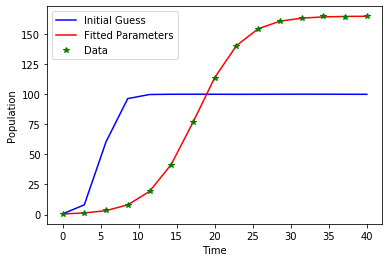

In [25]:
def log_residuals(params):
    sim_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=params, t_eval=t_points)
    return sim_data.y[0] - data_log[0]

initial_params = (1, -0.01)
fitted_params = optimize.least_squares(log_residuals, initial_params, method='lm')

initial_guess = integrate.solve_ivp(log_equation, (t0,tf), x0, args=initial_params, t_eval=t_points)
fitted_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=fitted_params.x, t_eval=t_points)

plt.plot(t_points, initial_guess.y[0], 'b-', label='Initial Guess')
plt.plot(t_points, fitted_data.y[0], 'r-', label='Fitted Parameters')
plt.plot(t_points, data_log[0], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

### Gradient matching

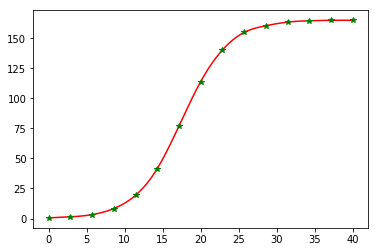

In [108]:
cs0 = interpolate.CubicSpline(t_points, data_log[0])
tnew = np.linspace(t0, tf, 500)

plt.plot(tnew,cs0(tnew), 'r-', label='interpolated x0')
plt.plot(t_points, data_log[0], 'g*', label='x0')
plt.show()

### Parameter cascading